# PubMed Abstract analysis

## Data source
Data was downloaded from
https://ironman.tenwisedev.nl/public/abstract_set1_michiel.txt
https://ironman.tenwisedev.nl/public/abstract_set2_michiel.txt

on feb 6, 2025
It was undisclosed which category the abstracts belonged to.

### All imports of the notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB # Naive Bayes

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import word_tokenize


### Utility functions

In [2]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    print("train score:", model.score(x_train, y_train))
    print("test score:", model.score(x_test, y_test))
    y_pred = model.predict(x_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    print(cnf_matrix)

In [3]:
class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(t) for t in tokens]

### Read and process the data

The files both have these columns:
`pmid title abstract`

In [4]:
set1 = pd.read_csv('./data/abstract_set1.txt', sep='\t')
set1.shape

(4944, 3)

In [5]:
set2 = pd.read_csv('./data/abstract_set2.txt', sep='\t')
set2.shape

(4950, 3)

In [6]:
set1['label'] = 1
set1.head()

,pmid,title,abstract,label
0,29990300,Oxidative stress in triazine pesticide toxicit...,This review article provides a summary of the ...,1
1,29990732,Toxicity induced by glyphosate and glyphosate-...,Glyphosate is the active component of many com...,1
2,29999060,Direct kinetics study of CH2OO + methyl vinyl ...,Methyl vinyl ketone (MVK) and methacrolein (MA...,1
3,30003825,Dihydromyricetin improves vascular hyporespons...,CONTEXT: Dihydromyricetin (DMY) has oxidation ...,1
4,30015122,Glyphosate and atrazine in rainfall and soils ...,The presence in the atmosphere of glyphosate (...,1


In [7]:
set2['label'] = 0
set2.head()

,pmid,title,abstract,label
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0


In [8]:
data = pd.concat([set1, set2])
print(data.shape)
# drop rows without abstract
data = data.dropna()
print(data.shape)
data.head()

(9894, 4)
(9110, 4)


,pmid,title,abstract,label
0,29990300,Oxidative stress in triazine pesticide toxicit...,This review article provides a summary of the ...,1
1,29990732,Toxicity induced by glyphosate and glyphosate-...,Glyphosate is the active component of many com...,1
2,29999060,Direct kinetics study of CH2OO + methyl vinyl ...,Methyl vinyl ketone (MVK) and methacrolein (MA...,1
3,30003825,Dihydromyricetin improves vascular hyporespons...,CONTEXT: Dihydromyricetin (DMY) has oxidation ...,1
4,30015122,Glyphosate and atrazine in rainfall and soils ...,The presence in the atmosphere of glyphosate (...,1


In [10]:
#remove punctuation
# punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
# transtab = str.maketrans(dict.fromkeys(punct, ''))
#df['text'] = '|'.join(df['text'].tolist()).translate(transtab).split('|')

# data['abstract'] = data['abstract'].str.translate(transtab)
# data['title'] = data['title'].str.translate(transtab)

## lowercasing
data['title'] = data['title'].str.lower()
data['abstract'] = data['abstract'].str.lower()

# combine title and abstract
data['all_text'] = data['title'] + " " + data['abstract']
data.head()

,pmid,title,abstract,label,all_text
0,29990300,oxidative stress in triazine pesticide toxicit...,this review article provides a summary of the ...,1,oxidative stress in triazine pesticide toxicit...
1,29990732,toxicity induced by glyphosate and glyphosate-...,glyphosate is the active component of many com...,1,toxicity induced by glyphosate and glyphosate-...
2,29999060,direct kinetics study of ch2oo + methyl vinyl ...,methyl vinyl ketone (mvk) and methacrolein (ma...,1,direct kinetics study of ch2oo + methyl vinyl ...
3,30003825,dihydromyricetin improves vascular hyporespons...,context: dihydromyricetin (dmy) has oxidation ...,1,dihydromyricetin improves vascular hyporespons...
4,30015122,glyphosate and atrazine in rainfall and soils ...,the presence in the atmosphere of glyphosate (...,1,glyphosate and atrazine in rainfall and soils ...


<Axes: >

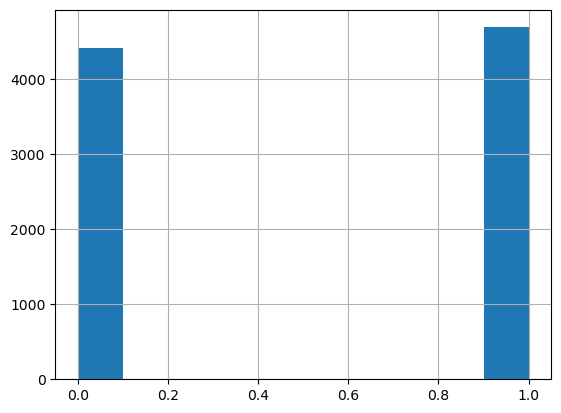

In [11]:
data['label'].hist()

### Create train and test data -- don't touch this!

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    data['title'], data['label'], random_state=123)

#y_test.head()

## Bag-of-Words classification using Multinomial Naive Bayes
### Tokenize

In [13]:
vectorizer = CountVectorizer(stop_words='english') #, tokenizer=StemTokenizer()# does not add to performance
x_train_cv = vectorizer.fit_transform(x_train)
x_test_cv = vectorizer.transform(x_test)
# Note the use of different functions for train and test data !

x_train_cv.shape # is a sparse matrix!

(6832, 15194)

In [14]:
# what percentage of values are non-zero?
(x_train_cv != 0).sum() / np.prod(x_train_cv.shape)

0.0006906865584498257

### apply model Naive Bayes

In [15]:
model = MultinomialNB() 
model.fit(x_train_cv, y_train)

evaluate_model(model, x_train_cv, y_train, x_test_cv, y_test)


train score: 0.9540398126463701
test score: 0.9016681299385426
[[1004  103]
 [ 121 1050]]


Notes:
* this model performs better when punctuation characters are not removed.
* classifying with `title` only is worse than with the `abstract`
* classifying with `all_text` is similar to only the `abstract`

## Markov model text classification

Steps:
1. Create mapping from unique word to unique integer index
2. Loop data, tokenize all text
3. create a special index for unknown words
4. convert each sample of text to integer representation
5. train a Markov model for each class
6. Don't forget to use smoothing and whether you need A and pi or log(A) and log(pi)
7. For Bayes'  rule: compute the priors: p(class=k)
8. Write a function to compute the posterior for each class, given an input
9. Take the argmax of the posteriors to get the predicted class
10. Make predictions for train/test
11. check class impalance
12. if imbalanced, check confusion matrix and F1 score
13. 

## First with example set

In [34]:
# !wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt
# !wget -nc https://raw.githubusercoantent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

--2025-02-12 16:04:37--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26622 (26K) [text/plain]
Saving to: ‘edgar_allan_poe.txt’

edgar_allan_poe.txt 100%[===================>]  26.00K  --.-KB/s    in 0.001s  

2025-02-12 16:04:37 (45.0 MB/s) - ‘edgar_allan_poe.txt’ saved [26622/26622]

--2025-02-12 16:04:37--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP re

In [33]:
input_files = [
  'data/edgar_allan_poe.txt',
  'data/robert_frost.txt',
]

In [34]:
!head data/edgar_allan_poe.txt

LO! Death hath rear'd himself a throne
In a strange city, all alone,
Far down within the dim west
Where the good, and the bad, and the worst, and the best,
Have gone to their eternal rest.
 
There shrines, and palaces, and towers
Are not like any thing of ours
Oh no! O no! ours never loom
To heaven with that ungodly gloom!


In [35]:
!head data/robert_frost.txt

Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth; 

Then took the other, as just as fair,
And having perhaps the better claim
Because it was grassy and wanted wear,
Though as for that the passing there


In [36]:
# collect data into lists
input_texts = []
labels = []

for label, f in enumerate(input_files):
  print(f"{f} corresponds to label {label}")

  for line in open(f):
    line = line.rstrip().lower()
    if line:
      # remove punctuation
      line = line.translate(str.maketrans('', '', string.punctuation))

      input_texts.append(line)
      labels.append(label)

data/edgar_allan_poe.txt corresponds to label 0
data/robert_frost.txt corresponds to label 1


In [37]:
x_train, x_test, y_train, y_test = train_test_split(input_texts, labels)
(len(y_train), len(y_test))

(1615, 539)

In [17]:
x_train[:5]

652     The effects of chlordane and rotenone on the a...
4431    Clinical features and power spectral entropy o...
2851    Phonemic verbal fluency decline after subthala...
4792    Effect of beta-cypermethrin on the reproductiv...
1317    Switching between simple cognitive tasks: the ...
Name: title, dtype: object

### Preprocess data -- PROCEED HERE WITH ABSTRACT DATA

In [16]:
idx = 1
word2idx = {'<unk>': 0}
# populate word2idx
for text in x_train:
    tokens = text.split()
    for token in tokens:
      if token not in word2idx:
        word2idx[token] = idx
        idx += 1

In [17]:
#word2idx
len(word2idx)

21433

In [20]:
# convert data into integer format
train_text_int = []
test_text_int = []

for text in x_train:
    tokens = text.split()
    line_as_int = [word2idx[token] for token in tokens]
    train_text_int.append(line_as_int)

for text in x_test:
    tokens = text.split()
    line_as_int = [word2idx.get(token, 0) for token in tokens] # default value of zero corresponds to the '<unk>' token
    test_text_int.append(line_as_int)

In [21]:
print(train_text_int[100:105])

[[44, 3, 976, 977, 978, 7, 466, 979, 980, 19, 8, 981], [982, 983, 5, 984, 985, 121, 19, 986, 22, 987, 988, 3, 989, 990], [991, 992, 993, 994, 995, 996, 997, 5, 998, 144, 8, 999, 464, 3, 953, 1000, 1001], [1002, 1003, 1004, 737, 19, 387, 349, 894, 123, 1005, 1006, 1007, 1008, 1009], [1010, 5, 1011, 1012, 1013, 5, 1014, 1015, 3, 1016, 19, 109, 1017, 1018, 1019, 7, 100, 1020, 896]]


In [22]:
print(len(word2idx)) # 129470
## initialize A and pi matrices - for both classes
V = len(word2idx) # V = Vocabulary size

## THIS IS JUST TOO MUCH GIVEN THE CURRENT DATASET!
A0 = np.ones((V, V)) # initialize with ones because of add-one smoothing
pi0 = np.ones(V)

A1 = np.ones((V, V))
pi1 = np.ones(V)

25375


In [23]:
# compute counts for A and pi
def compute_counts(text_as_int, A, pi):
    for tokens in text_as_int: # looping each line of the text represented as ints
        last_idx = None        # to keep track whether A or pi are populated
        for idx in tokens:
            if last_idx is None:
                # it's the first word in a sentence
                pi[idx] += 1
            else:
                # the last word exists, so count a transition
                A[last_idx, idx] += 1

            # update last idx
            last_idx = idx

#populate for labels 0 and 1
compute_counts([t for t, y in zip(train_text_int, y_train) if y == 0], A0, pi0) 
compute_counts([t for t, y in zip(train_text_int, y_train) if y == 1], A1, pi1)

In [24]:
# normalize A and pi so they are valid probability matrices
# convince yourself that this is equivalent to the formulas shown before
A0 /= A0.sum(axis=1, keepdims=True) # rows must sum to one; keepdims=True ensures that the sumn is still 2-dimensional
pi0 /= pi0.sum()

A1 /= A1.sum(axis=1, keepdims=True)
pi1 /= pi1.sum()

In [25]:
# log A and pi since we don't need the actual  -> axis = 1
logA0 = np.log(A0)
logpi0 = np.log(pi0)

logA1 = np.log(A1)
logpi1 = np.log(pi1)

In [26]:
# compute priors
count0 = sum(y == 0 for y in y_train)
count1 = sum(y == 1 for y in y_train)
print(count0, count1)
total = len(y_train)
p0 = count0 / total
p1 = count1 / total
logp0 = np.log(p0)
logp1 = np.log(p1)
p0, p1

3311 3521


(0.48463114754098363, 0.5153688524590164)

When p0 and p1 are reosonably close, it does not makes sence to use the maximum likelyhood method; 
instead look at the posterior which correponds to the map(?) method.
Since the classes are (slightly) imbalanced, a metric other than accuracy is approprioate: f1-score


In [27]:
# build a classifier
class Classifier:
    def __init__(self, logAs, logpis, logpriors):
        self.logAs = logAs
        self.logpis = logpis
        self.logpriors = logpriors
        self.K = len(logpriors) # number of classes

    def _compute_log_likelihood(self, input_, class_):
        '''uses an input text (as ints) and a proposed class'''
        logA = self.logAs[class_]
        logpi = self.logpis[class_]

        last_idx = None
        logprob = 0
        for idx in input_:
            if last_idx is None:
                # it's the first token
                logprob += logpi[idx]
            else:
                logprob += logA[last_idx, idx]
            # update last_idx
            last_idx = idx
        return logprob
  
    def predict(self, inputs):
        predictions = np.zeros(len(inputs))
        for i, input_ in enumerate(inputs):
            posteriors = [self._compute_log_likelihood(input_, c) + self.logpriors[c] \
                 for c in range(self.K)]
            pred = np.argmax(posteriors)
            predictions[i] = pred
        return predictions

In [28]:
# each array must be in order since classes are assumed to index these lists
clf = Classifier([logA0, logA1], [logpi0, logpi1], [logp0, logp1])

In [29]:
Ptrain = clf.predict(train_text_int)
print(f"Train acc: {np.mean(Ptrain == y_train)}")

Train acc: 0.9961943793911007


In [30]:
Ptest = clf.predict(test_text_int)
print(f"Test acc: {np.mean(Ptest == y_test)}")

Test acc: 0.8143107989464442


In [31]:
from sklearn.metrics import confusion_matrix, f1_score

# read about F-score: https://en.wikipedia.org/wiki/F-score

In [32]:
cm = confusion_matrix(y_train, Ptrain)
cm

array([[3297,   14],
       [  12, 3509]])

In [33]:
cm_test = confusion_matrix(y_test, Ptest)
cm_test

array([[ 825,  282],
       [ 141, 1030]])

In [34]:
f1_score(y_train, Ptrain)

0.9963089153889836

In [35]:
f1_score(y_test, Ptest)

0.8296415626258559